In [1]:
import tensorflow as tf 
print(tf.__version__) 
tf.test.is_gpu_available()

2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8048545769459327681
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6300696576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1031789658732914003
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import numpy as np
import pandas as pd

from math import ceil
from numba import njit, prange
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import os
import cv2

In [4]:
Welding_data = np.load('E:/3.17/MTF/MTF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [5]:
print(y_data)

[0 0 2 ... 0 1 2]


In [6]:
seed = 7
np.random.seed()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_data,y_data,i_data, test_size = 0.2, shuffle = True, random_state = seed)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2400, 300, 300, 2)
(2400,)
(600, 300, 300, 2)
(600,)


In [8]:
inputs = np.concatenate((X_train,X_test))
targets = np.concatenate((y_train,y_test))
index = np.concatenate((i_train,i_test))

In [9]:
targets = np_utils.to_categorical(targets)
print(targets)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
import tensorflow as tf

In [11]:
# DenseNet

In [12]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Input, Activation, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization.batch_normalization import BatchNormalization

In [13]:
input = Input(shape=(300, 300, 2))
model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
 
x = model.output
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax', name='softmax')(x)

model = Model(model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 2  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 306, 306, 2)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  6272        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
import keras.backend as K

from keras.callbacks import Callback

class LearningRateSchedule(Callback):
    def __init__(self, selected_epochs=[]):
        self.selected_epochs = selected_epochs
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) in self.selected_epochs:
            lr = K.get_value(self.model.optimizer.lr)
            K.set_value(self.model.optimizer.lr, lr*0.1)

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

test = []
train= []
test_ = []
train_ = []
for train, test in kfold.split(inputs, targets):
    print(len(test))
    print(len(train))
    for i in zip(test):
        test_.append(i)
    for i in zip(train):
        train_.append(i)

300
2700
300
2700
300
2700
300
2700
300
2700
300
2700
300
2700
300
2700
300
2700
300
2700


In [16]:
train = train_[0:2700]
train = np.reshape(train, 2700)
test = test_[0:300]
test = np.reshape(test, 300)

In [17]:
print(test)
print(train)
print(index[test])
print(targets[test])

[   2   34   36   70   99  118  121  125  142  151  172  180  186  190
  203  206  224  259  278  280  296  314  318  325  340  356  361  372
  375  377  386  412  414  415  419  420  423  426  429  430  433  440
  454  456  468  474  514  526  532  536  539  561  562  568  582  584
  587  592  631  637  643  658  672  674  684  699  707  718  720  727
  729  732  734  735  737  750  752  770  773  785  802  803  804  807
  819  832  852  855  858  868  871  879  883  890  891  928  933  964
  974  979  983  992 1038 1051 1054 1057 1073 1077 1098 1102 1104 1109
 1111 1123 1140 1141 1159 1162 1163 1164 1166 1181 1205 1210 1224 1229
 1235 1242 1271 1306 1327 1351 1363 1377 1381 1389 1391 1396 1426 1435
 1443 1448 1459 1463 1476 1483 1495 1513 1528 1530 1541 1543 1547 1564
 1598 1600 1609 1611 1622 1634 1647 1667 1670 1698 1705 1707 1732 1734
 1740 1742 1745 1759 1784 1806 1813 1845 1853 1877 1897 1898 1910 1963
 1966 1968 1989 1992 2004 2037 2043 2051 2052 2054 2077 2087 2090 2101
 2106 

In [18]:
# K-fold Cross-validation

In [19]:

os.mkdir('E:/3.18/MTF2' + '/' + 'train')
os.mkdir('E:/3.18/MTF2' + '/' + 'test')
os.mkdir('E:/3.18/MTF2/' + 'weight')


In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

acc_per_fold = []
loss_per_fold = []

kfold = StratifiedKFold(n_splits=10, shuffle=True)

fold_no = 1

with tf.device('/gpu:0'):
    for train, test in kfold.split(X_train, y_train):
        print(train.shape, test.shape)
        
        np.savetxt('E:/3.18/MTF2/train/' + f'train_{fold_no}.csv', train, delimiter=",")
        np.savetxt('E:/3.18/MTF2/test/' + f'test_{fold_no}.csv', test, delimiter=",")

        input = Input(shape=(300, 300, 2))
        model = DenseNet121(input_tensor=input, include_top=False, weights=None, pooling='avg')
        
        x = model.output

        x = Dense(3, activation='softmax', name='softmax', kernel_initializer='he_normal')(x)
        model = Model(model.input, x)

        
        optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        #optimizer = optimizers.Adam(lr=0.001)
        
        callbacks_list = [LearningRateSchedule([20,40])]
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        history = model.fit(inputs[train], targets[train], 
                            batch_size=4, 
                            epochs=100, 
                            verbose=1,
                            validation_data=(inputs[test], targets[test]),
                            callbacks = callbacks_list) # 여기에 Validation set을 넣어야되는거 아닌가?
        
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        
        model.save('E:/3.18/MTF/weight/' + f'MTF_{fold_no}.h5',fold_no)
        
        fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

(2160,) (240,)


C:\Users\JWH\anaconda3\envs\tf2.0-gpu\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
540/540 [==============================] - 81s 121ms/step - loss: 0.3120 - accuracy: 0.8042 - val_loss: 0.6473 - val_accuracy: 0.6333
Epoch 2/100
540/540 [==============================] - 64s 118ms/step - loss: 0.2219 - accuracy: 0.8690 - val_loss: 0.1361 - val_accuracy: 0.9292
Epoch 3/100
540/540 [==============================] - 62s 115ms/step - loss: 0.1930 - accuracy: 0.8894 - val_loss: 0.2196 - val_accuracy: 0.8000
Epoch 4/100
540/540 [==============================] - 63s 117ms/step - loss: 0.1716 - accuracy: 0.9019 - val_loss: 0.1538 - val_accuracy: 0.9125
Epoch 5/100
540/540 [==============================] - 62s 114ms/step - loss: 0.1539 - accuracy: 0.9204 - val_loss: 0.1362 - val_accuracy: 0.9250
Epoch 6/100
540/540 [==============================] - 62s 115ms/step - loss: 0.1346 - accuracy: 0.9315 - val_loss: 0.1303 - val_accuracy: 0.9250
Epoch 7/100
540/540 [======

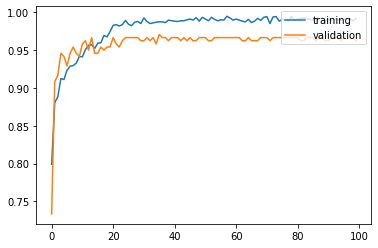

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc='upper right')
plt.show()

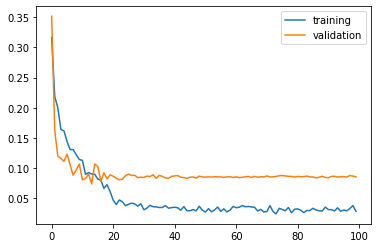

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'], loc='upper right')
plt.show()